<a href="https://colab.research.google.com/github/brayvid/EpidemicSimulator/blob/master/epidemic_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Epidemic Simulator</h1>

<h3>WARNING: This program is not a reliable source of epidemiological information. Do not use it for anything important. Bugs are guaranteed.</h3>

<h4>Description:<h4>
<p>This simulates a disease spreading through a community in random motion. Parameters include the population and overall population density, the number of trials to conduct, and the number of units that an individual should move per timestep per unit of 'playable' area. Individuals are represented as points undergoing independent random walks in a bounded two dimensional environment. After a random period of time between a given minimum and maximum, infected individuals either recover or die. The probability of death varies by age group: <a href="https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics">https://worldometers.info/coronavirus/coronavirus-age-sex-demographics</a> and <a href="https://newyork.areaconnect.com/statistics.htm">https://newyork.areaconnect.com/statistics.htm</a>.</p>

<h4>Usage:<h4>
<p>1) Save your own copy of this notebook to your Google Drive (once in the Colab environment) by selecting File (next to Colab logo at top left) --> Save a copy in Drive.<br>
2) In the top right corner of the new window that appears, click Connect to allocate some of Google's computing resources.<br>
3) Edit the parameters in the section called User Inputs below if desired.<br>
4) Select Runtime (to the right of File) --> Run all.<br>
5) Check the estimated computation time in the last section of the notebook. If an abort is required, click the stop sign on the left.<br>
6) Repeat steps 3-5 as desired.</p>

<h4>Note:<h4>
<p>The code is not optimized for speed. For a reasonable compute time, keep the number of trials, timesteps and individuals small. The program will estimate the compute time before running so the user can abort if necessary.</p>

<h4>Random variables used:<h4>
<p>- The direction in which an individual moves each time step is a continuous uniform random variable $\Theta \sim U(0,2\pi)$.<br>
- The number of days in which an individual remains infected is a discrete uniform random variable $I \sim U\{l,u\}$, where $l \leq u$ are provided by the user.</p>

<h4>Formulas used:</h4>
<p>- For $N$ individuals and positive population density $\rho$, the side length of the box is $A=\sqrt{\frac{N}{\rho}}$.<br>
- For a fixed box length $A$ and a user-provided step-to-bound ratio $D$, each individual's step size per unit time is $R=AD$.<br>
- Given $\theta$, a sample from $\Theta$, an individual's displacement per timestep is given by $\Delta X = R \cos{\theta}, \Delta Y = R \sin{\theta}$.
</p>


### User inputs

In [0]:
# EDIT

# Simulation parameters                   # [Plot label] Description (Range)                            
inputNumberTrials = 10                    # [trials] How many trials to conduct and average (1+)
inputTimeSteps = 150                      # [given by upper bound of X-axis] How many steps to simulate per trial (1 step = 1 day)
inputPopulationSize = 3000                # [pop] Total number of individuals to simulate per trial (multiples of 100, 100+)

# Trial parameters
inputStepToBoundRatio = 0.145             # [step/bound] Fraction of the grid length that a person travels in one timestep (0.0+) 
inputPopulationDensity = 0.026            # [density] Millions per square mile (0.0+)                  
inputMaxTimeContagious = 25               # [contagious_days(hi)] Guaranteed closed case by then
inputMinTimeContagious = 10               # [contagious_days(lo)] Minimum time to close case

# Preferences
inputSaveToDrive = True                  # [n/a] Save figure and data to connected Google Drive: False -> normal browser download (True, False)

# END EDITABLE

### Modules

In [0]:
import numpy as np
# from scipy.stats import invgauss
import matplotlib.pyplot as plt
import time
import csv
from google.colab import files

### Structures

In [0]:
# Blueprint for an individual in this model
class Person:
  # properties: position, age, and infection status
    def __init__(self, x, y, age, status, ind):
      self.x = x
      self.y = y
      self.age = age
      self.status = status
      self.update_t = 0
      self.index = ind

    def move(self):
      # Random angle from 0 to 360 degrees
      theta = np.random.uniform(0, 2*np.pi)
      # Semi-random displacement (base + some noise)
      # rad = baseStep + invgauss.cdf(np.random.uniform(), 100)
      rad = baseStep
      dx = rad * np.cos(theta)
      dy = rad * np.sin(theta)
      self.x += dx
      self.y += dy
      
      # Constrain position
      if(self.x < 0):
        self.x = 0
      if(self.x > bound):
        self.x = bound
      if(self.y < 0):
        self.y = 0
      if(self.y > bound):
        self.y = bound
      
    def update(self, status, t):
      self.status = status
      self.update_t = t

# Determines if a transmission occurs
def transmit(pers, rad):
  # 0 = Susceptible; 1 = Infected; 2 = Recovered
  # A status change is only possible when one person is susceptible and one is infected
  if(np.random.uniform() > rad): # transmit with probability given
      return 1 
  # otherwise no change
  return 0

# Pythagorean distance formula
def dist(p1, p2):
  return np.sqrt((p2.x - p1.x) ** 2 + (p2.y - p1.y) ** 2)

# Constrains the user-inputted parameters, ensuring the simulation is logical
def updateProgramVars():
  global C
  C = 1
  global N
  N = int((100 if inputPopulationSize < 100 else inputPopulationSize) / C) # fix population size
  global bound
  bound = np.sqrt(N / (C * inputPopulationDensity)) if inputPopulationDensity > 0 else np.sqrt(N)
  # print("bound = ", np.around(bound,2))
  global timesteps
  timesteps = int(2 if inputTimeSteps < 2 else inputTimeSteps)
  global numTrials
  numTrials = int(1 if inputNumberTrials < 1 else inputNumberTrials) 
  global baseStep
  baseStep = 0 if inputStepToBoundRatio < 0 else (inputStepToBoundRatio * bound)
  global minContagious
  minContagious = 1 if inputMinTimeContagious < 1 else inputMinTimeContagious
  global maxContagious
  maxContagious = minContagious if inputMaxTimeContagious < minContagious else inputMaxTimeContagious
  
  # Community age demographics (NYC data: https://newyork.areaconnect.com/statistics.htm)
  # Ranges: [0-4, 5-9, 10-14, 15-19, 20-24, 25-34, 35-44, 45-54, 55-59, 60-64, 65-74, 75-84, 85+]
  global popAges
  popAges = [2, 7, 12, 17, 22, 30, 40, 50, 57, 62, 70, 80, 85] # Only one age per range needed
  global popDemo
  popDemo = [7, 7,  7,  6,  7, 17, 16, 13,  5,  4,  6,  4, 2 ] # per hundred

  # Probability of death by age group (Global data: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/)
  # [0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80+]
  global deathAges
  deathAges = [-1, 9, 19, 29, 39, 49, 59, 69, 79, 89] # upper bound for range
  global deathRates
  deathRates = [0, 0.002, 0.002, 0.002, 0.004, 0.013, 0.036, 0.08, 0.148]

### Sim code

In [0]:
def simulate():
  updateProgramVars() # load most recently entered parameters into memory

  # Estimate compute time
  ops = numTrials * (
      len(popAges) * int(N*C/100) +
      N*C +
      timesteps * (
          N*C*(len(deathAges) - 1) +
          N*C +
          (N*C - 1) * (N*C) / 2
      )   
  ) + 4 * (timesteps + 1) * numTrials
  
  # Display running time estimate
  print('Est. running time: ' + str(round(ops / (C * 357358))) + 's (???)')
  
  # Loading bar animation begin
  print('[' + " " * 49 + ']', end="")
  anim_step = 0

  # Storage for program outputs
  DATA = [[],[],[],[]]
  POPS = []
  REPRODS = np.zeros((numTrials, timesteps + 1))

  # Timekeeping
  beginTime = time.time()
  trialTimes = []

  # Run all trials
  for sim in range(numTrials):
    trialStartTime = time.time()
    
    # Initialize population
    population = []
    ages = []
    
    # Generate age assignments from distribution given in Structures section
    for i in range(len(popAges)): # for each age group
      for j in range(int((N*C/100) * popDemo[i])):
        ages.append(popAges[i])
    
    # Assign random XY locations
    randX = np.random.uniform(0, bound, N)
    randY = np.random.uniform(0, bound, N)
    for j in range(N):
      population.append(Person(randX[j], randY[j], ages[j], 0, j))
    
    # Randomly assign one initial infection
    ppl_infected = np.random.choice(N)
    population[ppl_infected].update(1, 0)
    
    # Place infected individual in center of community (i.e. transport hub)
    population[ppl_infected].x = bound / 2
    population[ppl_infected].y = bound / 2

    # Data storage
    SUSCEPTIBLE = np.zeros(timesteps + 1)
    INFECTED = np.zeros(timesteps + 1)
    RECOVERED = np.zeros(timesteps + 1)
    DEATHS = np.zeros(timesteps + 1)

    # Original index of initial infected
    INDICES_INFECTED = [ppl_infected]
    INDICES_RECOVERED = []
    INDICES_DECEASED = []

    # print('init_infected: ', ppl_infected)

    # All other indices
    INDICES_SUSCEPTIBLE = list(filter(lambda x : x != ppl_infected, range(N)))

    # Initial data points
    SUSCEPTIBLE[0] = N*C - 1
    INFECTED[0] = 1

    # Infection network
    WHO_INFECTS = []
    WHO_THEY_INFECT = []

    # Step counter
    current_t = 0
  
    # Evolve the system
    for i in range(timesteps):
      # Update step counter
      current_t = current_t + 1
      anim_step += 1

      # Temporary storage for reproduction number calculation data
      REPROD_THIS_STEP = [0,0] # [#infectors, #infected]
      
      # Check for any people with infections ending and determine if death occurred
      for j in INDICES_INFECTED:
        # print('recovered_check: ', j)
        if current_t - population[j].update_t > np.random.choice(np.arange(minContagious,maxContagious+1)): # infection over
          this_age = population[j].age
          for k in range(len(deathAges) - 1):
            if (this_age <= deathAges[k+1]) and (this_age > deathAges[k]):
              this_prob = deathRates[k]
          if np.random.uniform() < this_prob: # death occurred
            population[j].update(3, current_t)
            DEATHS[i+1] += 1
            INDICES_DECEASED.append(j) 
          else: # patient survived
            population[j].update(2, current_t)
            RECOVERED[i+1] += 1
            INDICES_RECOVERED.append(j)
          INDICES_INFECTED = list(filter(lambda x : x != j, INDICES_INFECTED)) # remove dead and recovered from infected list
        else: # stays infected
            INFECTED[i+1] += 1
      
      # Record current number of susceptible individuals
      SUSCEPTIBLE[i+1] = N - len(INDICES_INFECTED) - len(INDICES_RECOVERED) - len(INDICES_DECEASED)
        
      # Update positions
      for j in range(N):
        population[j].move()

      # Compare and update statuses
      for lcomp in INDICES_INFECTED:
        # print('potential_infectors: ', lcomp)
        for rcomp in INDICES_SUSCEPTIBLE:
          # print('potential_infected', rcomp)
          d = dist(population[lcomp], population[rcomp])
          if(d < 1): # close enough proximity
            result = transmit(population[rcomp], d) # returns new status for susceptible
            # Only check if second person (rcomp) status changed      
            if population[rcomp].status != result: # susceptible individual was infected
              # print('new infection: ', rcomp)
              population[rcomp].update(result, current_t) # P1 ---> P2
              INDICES_SUSCEPTIBLE = list(filter(lambda x : x != rcomp, INDICES_SUSCEPTIBLE)) # remove new infected index from susceptible indices
              INDICES_INFECTED = INDICES_INFECTED + [rcomp]
              if lcomp not in WHO_INFECTS: # first time infecting someone
                WHO_INFECTS.append(lcomp)
                WHO_THEY_INFECT.append([rcomp])
                REPROD_THIS_STEP[0] += 1
                REPROD_THIS_STEP[1] += 1
              else: # have infected someone already
                WHO_THEY_INFECT[list(WHO_INFECTS).index(lcomp)] = WHO_THEY_INFECT[list(WHO_INFECTS).index(lcomp)] + [rcomp]
                REPROD_THIS_STEP[1] += 1

      # Record the reproduction number for the trial   
      REPRODS[sim][i + 1] = (1 + REPROD_THIS_STEP[1] / REPROD_THIS_STEP[0]) if REPROD_THIS_STEP[0] > 0 else 0
      
      # Update loading bar animation
      print('\r[#' + "#" * int(49*(anim_step)/(numTrials*timesteps)) + " " * (49 - int(49*(anim_step)/(numTrials*timesteps))) + ']', end="")

    # Record all data for this trial
    DATA[0].append(SUSCEPTIBLE)
    DATA[1].append(INFECTED)
    DATA[2].append(RECOVERED)
    DATA[3].append(DEATHS)
    POPS.append(population)     

  # Average over all trials for each timestep
  AVG_DATA = np.mean(DATA, axis=1)
  STDEV_DATA = np.std(DATA, axis=1)

  # Generate expected timeseries scaled to 100%
  infected_series = np.array(AVG_DATA[1]) * (100/(N*C))
  susceptible_series =  np.array(AVG_DATA[0]) * (100/(N*C))
  recovered_series = np.cumsum(np.array(AVG_DATA[2]) * (100/(N*C)))
  deceased_series = np.cumsum(np.array(AVG_DATA[3]) * (100/(N*C)))
  reprod_series = np.mean(REPRODS,0)

  # Generate bounding data scaled to 100% for infected
  AVG_STD_ABOVE = AVG_DATA + STDEV_DATA
  AVG_STD_BELOW = AVG_DATA - STDEV_DATA
  infected_series_std_up = np.array(AVG_STD_ABOVE[1]) * (100/(N*C))
  infected_series_std_down = np.array(AVG_STD_BELOW[1]) * (100/(N*C))

  # Plot population dynamics for expected case
  # Overall figure
  palette = ["#2a385b", "#8b7f47", "#9c9eb5", "#8b0000"]
  fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,16), dpi=144)
  title1 = 'Epidemic Simulation (trials = ' + str(numTrials) + '; pop = ' + str(N*C) + ')'
  title2 = '\nmove/bound = ' + str(np.around(baseStep / bound,3)) + '; contagious_days = ' + str(minContagious) + ':' + str(maxContagious)
  ticks = np.arange(0,timesteps+1,30)

  susceptible_pct = np.array(AVG_DATA[0][-1]) * (100/(N*C))
  infected_pct = 100.0 - susceptible_pct
  recovered_pct = (100 * 100 / (N * C * infected_pct)) * sum(np.array(AVG_DATA[2]))     # Percentage of cases, not of population
  deceased_pct = (100/(N*C)) * sum(np.array(AVG_DATA[3]))                               # Percentage of cases, not of population 
  
  # Compute percentage deceased of whole population
  DEC_PCT_OF_N = 0.0001 * deceased_pct * infected_pct

  # Best guess plot
  lb_1 = 'Infected (' + str(np.around(infected_pct,2)) + '%)'                                     
  lb_2 = 'Susceptible (' + str(np.around(susceptible_pct,2)) + '%)'                               
  lb_3 = 'Recovered (' + str(np.around(100 if recovered_pct > 100 else recovered_pct,2)) + '%)'  
  lb_4 = 'Deceased (' + str(np.around(deceased_pct,4)) + '%)'              
  subtitle = '==> max_reprod = ' + str(np.around(np.max(reprod_series),3)) + '; pop_dead = '+ str(np.around(100 * DEC_PCT_OF_N, 5))  + '%\n'
  ax1.set_title(title1+title2+'\n' + subtitle)
  ax1.stackplot(np.arange(timesteps+1), infected_series, susceptible_series, recovered_series, deceased_series, labels=[lb_1, lb_2, lb_3, lb_4], colors = palette, alpha = 0.5)
  ax1.legend(loc=(0.7,0.75))
  ax1.set_xlabel('Days after first infection')
  ax1.set_ylabel('% population')
  ax1.margins(x=0, y=0)
  ax1.set_xticks(ticks)
  ax1.grid(which='major', alpha=0.5)

  # 10 day moving average
  rollmean = [0] * 10
  for i in range(10, timesteps + 1):
    this_avg = np.mean(np.array([infected_series[i-9] - infected_series[i-10],infected_series[i-8] - infected_series[i-9],infected_series[i-7] - infected_series[i-8],infected_series[i-6] - infected_series[i-7],infected_series[i-5] - infected_series[i-6],infected_series[i-4] - infected_series[i-5],infected_series[i-3] - infected_series[i-4],infected_series[i-2] - infected_series[i-3],infected_series[i-1] - infected_series[i-2], infected_series[i] - infected_series[i-1]]))
    rollmean.append(this_avg)
  # rollmean <-> number infected
  max_rollmean = max(rollmean)  # percentage of population
  rollmean = np.array(rollmean)
  
  # one stdev up
  rollmean_up = [0] * 11
  for i in range(11, timesteps + 1):
    this_avg = np.mean(np.array([infected_series_std_up[i-10] - infected_series_std_up[i-11], infected_series_std_up[i-9] - infected_series_std_up[i-10],infected_series_std_up[i-8] - infected_series_std_up[i-9],infected_series_std_up[i-7] - infected_series_std_up[i-8],infected_series_std_up[i-6] - infected_series_std_up[i-7],infected_series_std_up[i-5] - infected_series_std_up[i-6],infected_series_std_up[i-4] - infected_series_std_up[i-5],infected_series_std_up[i-3] - infected_series_std_up[i-4],infected_series_std_up[i-2] - infected_series_std_up[i-3],infected_series_std_up[i-1] - infected_series_std_up[i-2], infected_series_std_up[i] - infected_series_std_up[i-1]]))
    rollmean_up.append(this_avg)
  # rollmean <-> number infected
  max_rollmean_up = max(rollmean_up)  # percentage of population
  rollmean_up = np.array(rollmean_up)

  # one stdev down
  rollmean_down = [0] * 11
  for i in range(11, timesteps + 1):
    this_avg = np.mean(np.array([infected_series_std_down[i-10] - infected_series_std_down[i-11], infected_series_std_down[i-9] - infected_series_std_down[i-10],infected_series_std_down[i-8] - infected_series_std_down[i-9],infected_series_std_down[i-7] - infected_series_std_down[i-8],infected_series_std_down[i-6] - infected_series_std_down[i-7],infected_series_std_down[i-5] - infected_series_std_down[i-6],infected_series_std_down[i-4] - infected_series_std_down[i-5],infected_series_std_down[i-3] - infected_series_std_down[i-4],infected_series_std_down[i-2] - infected_series_std_down[i-3],infected_series_std_down[i-1] - infected_series_std_down[i-2], infected_series_std_down[i] - infected_series_std_down[i-1]]))
    rollmean_down.append(this_avg)
  # rollmean <-> number infected
  max_rollmean_down = max(rollmean_down)  # percentage of population
  rollmean_down = np.array(rollmean_down)

  # Shift moving averages 5 units left
  rollmean = np.roll(rollmean,-5)
  rollmean_up = np.roll(rollmean_up,-5)
  rollmean_down = np.roll(rollmean_down,-5)
  ax2.margins(x=0, y=0)
  ax2.set_title('Daily Δ expected infections, centered 10-day moving average')
  ax2.set_xlim(left=0, right=timesteps)
  ax2.plot(np.arange(timesteps+1)[(5-1):-(5-1)], rollmean[(5-1):-(5-1)], '-b')
  ax2.fill_between(np.arange(timesteps+1)[(5-1):-(5-1)], rollmean_up[(5-1):-(5-1)], rollmean_down[(5-1):-(5-1)], facecolor='blue', alpha=0.1)

  # Cover up beginning and end of curve
  ax2.fill_between(np.arange(5),ax2.get_ylim()[1] * np.ones(5), ax2.get_ylim()[0] * np.ones(5), fc='k', alpha=0.1)
  ax2.fill_between(np.arange(timesteps + 1 - 5, timesteps + 1),ax2.get_ylim()[1] * np.ones(5), ax2.get_ylim()[0] * np.ones(5), fc='k', alpha=0.1)
  ax2.set_xlabel('Days after first infection')
  ax2.set_ylabel('% population')
  ax2.set_xticks(ticks)
  ax2.grid(which='major', alpha=0.5)
  ax2.legend(['Expected','+/- 1σ'])
  ax2.plot(np.arange(timesteps+1), np.zeros(timesteps+1),'--k')

  # Generate unique unix timestamp for file ID
  time_complete = time.time()
  output_unix_t = str(int(time_complete))
  runtime_sec = np.around(time_complete - beginTime,1)

  # CSV-friendly data format
  output_data = [["Timestep", "Susceptible", "Infected", "Recovered", "Deceased","Reproduction"]]
  for i in range(timesteps + 1):
    output_data.append([i, np.around(susceptible_series[i],6), np.around(infected_series[i],6), np.around(recovered_series[i],6), np.around(deceased_series[i] * infected_pct / 100,6), (np.around(reprod_series[i-1],6)) if i > 0 else 0.0])

  # Save and display outputs
  if inputSaveToDrive:
    plt.savefig('/content/drive/My Drive/EpidemicSimulatorResults/Plots/plot_'+ output_unix_t + '.png', dpi=144, bbox_inches='tight')
    with open('/content/drive/My Drive/EpidemicSimulatorResults/Data/data_'+ output_unix_t + '.csv', 'w', newline='\n') as file:
      writer = csv.writer(file)
      writer.writerows(output_data)
  else:
    plt.savefig('plot_'+ output_unix_t + '.png', dpi=144, bbox_inches='tight')
    with open('data_'+ output_unix_t + '.csv', 'w', newline='\n') as file:
      writer = csv.writer(file)
      writer.writerows(output_data)
    files.download('plot_'+ output_unix_t + '.png')
    files.download('data_'+ output_unix_t + '.csv')
  print("\rElapsed time: " + str(runtime_sec) + 's')
  print('Output ID: ' + output_unix_t)
  plt.show()

### Run sim

Est. running time: 2139s (???)
Elapsed time: 28.4s
Output ID: 1586441364


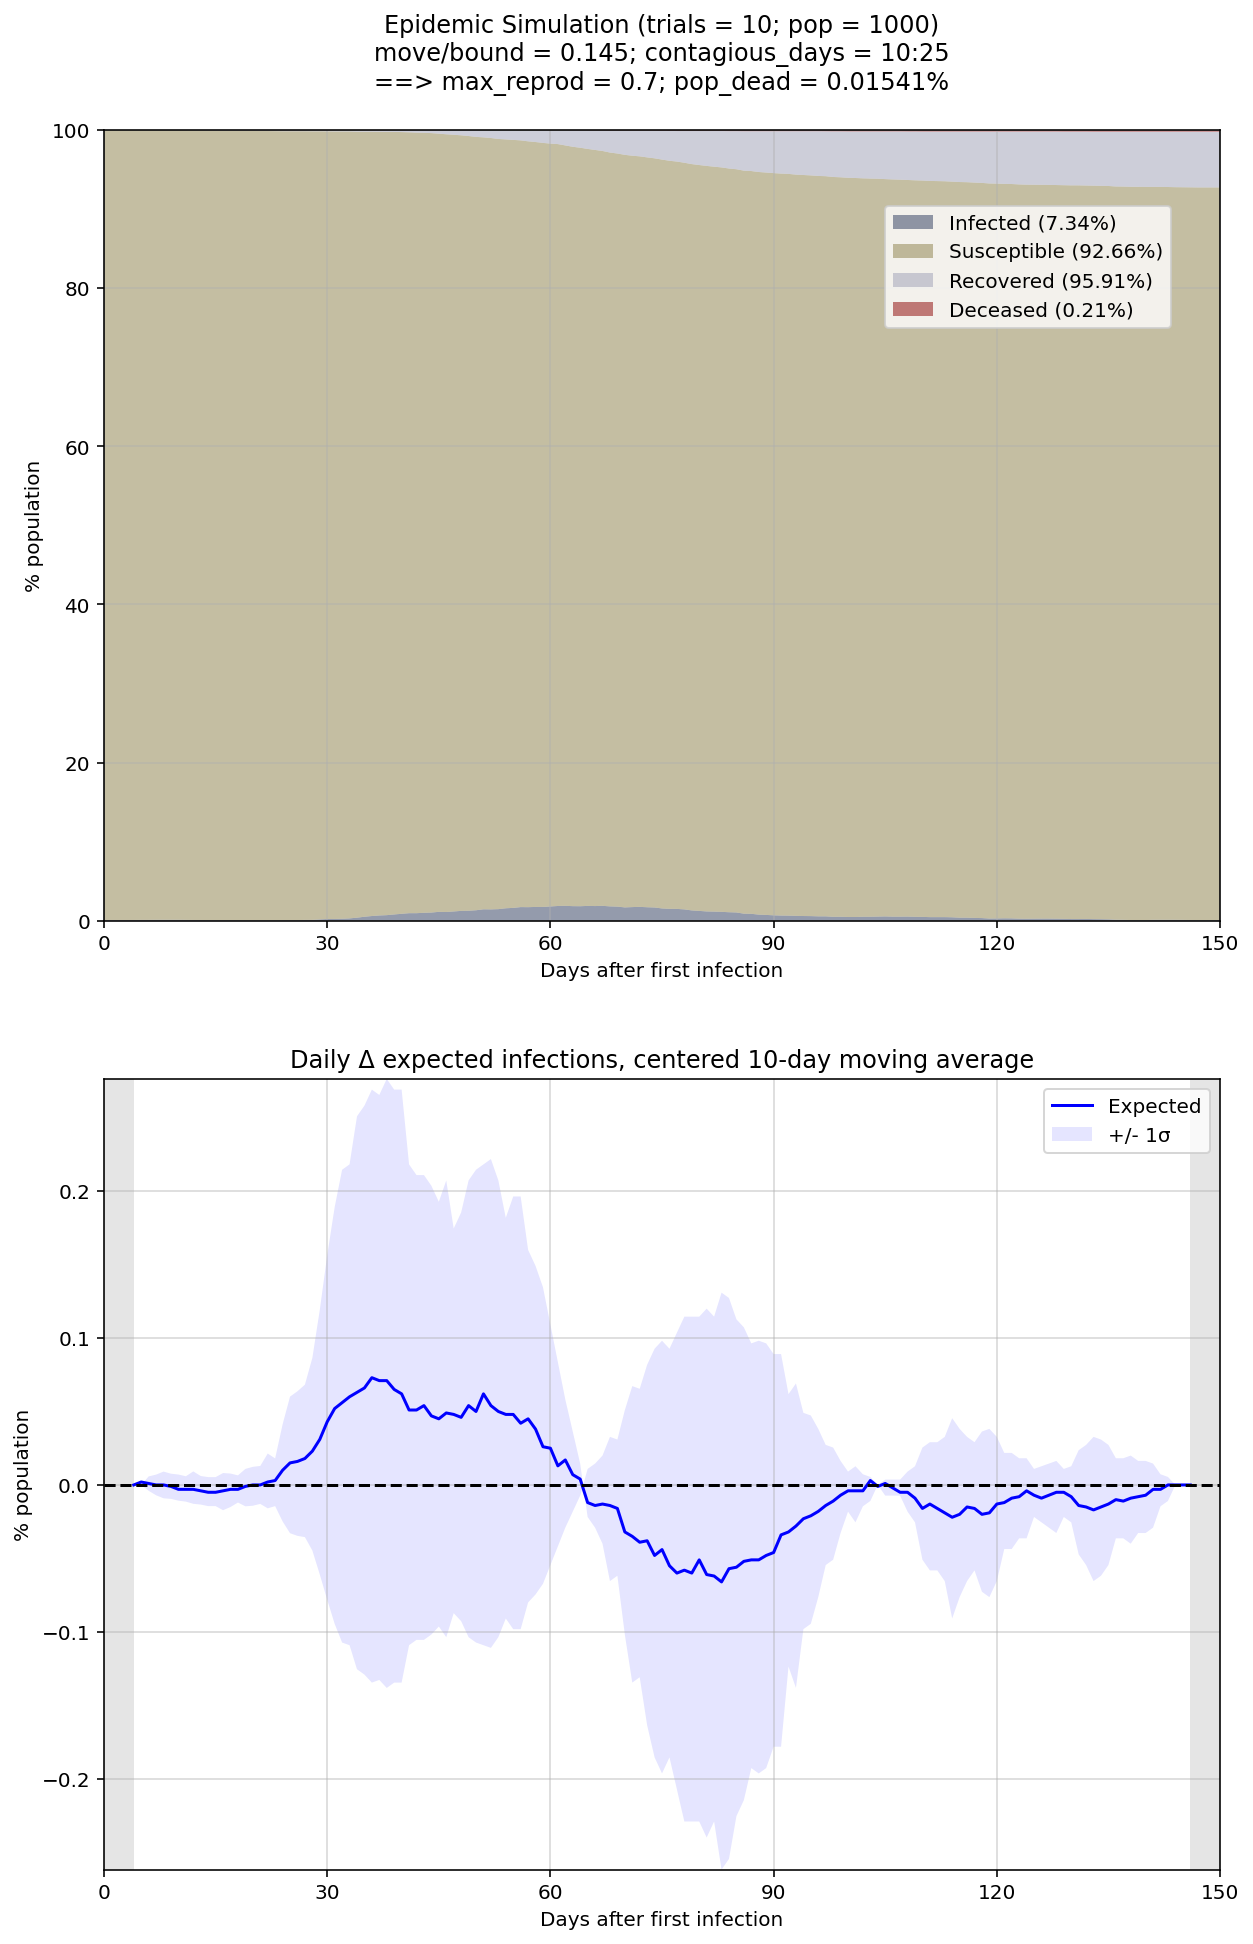

Est. running time: 8475s (???)
Elapsed time: 220.5s
Output ID: 1586441591


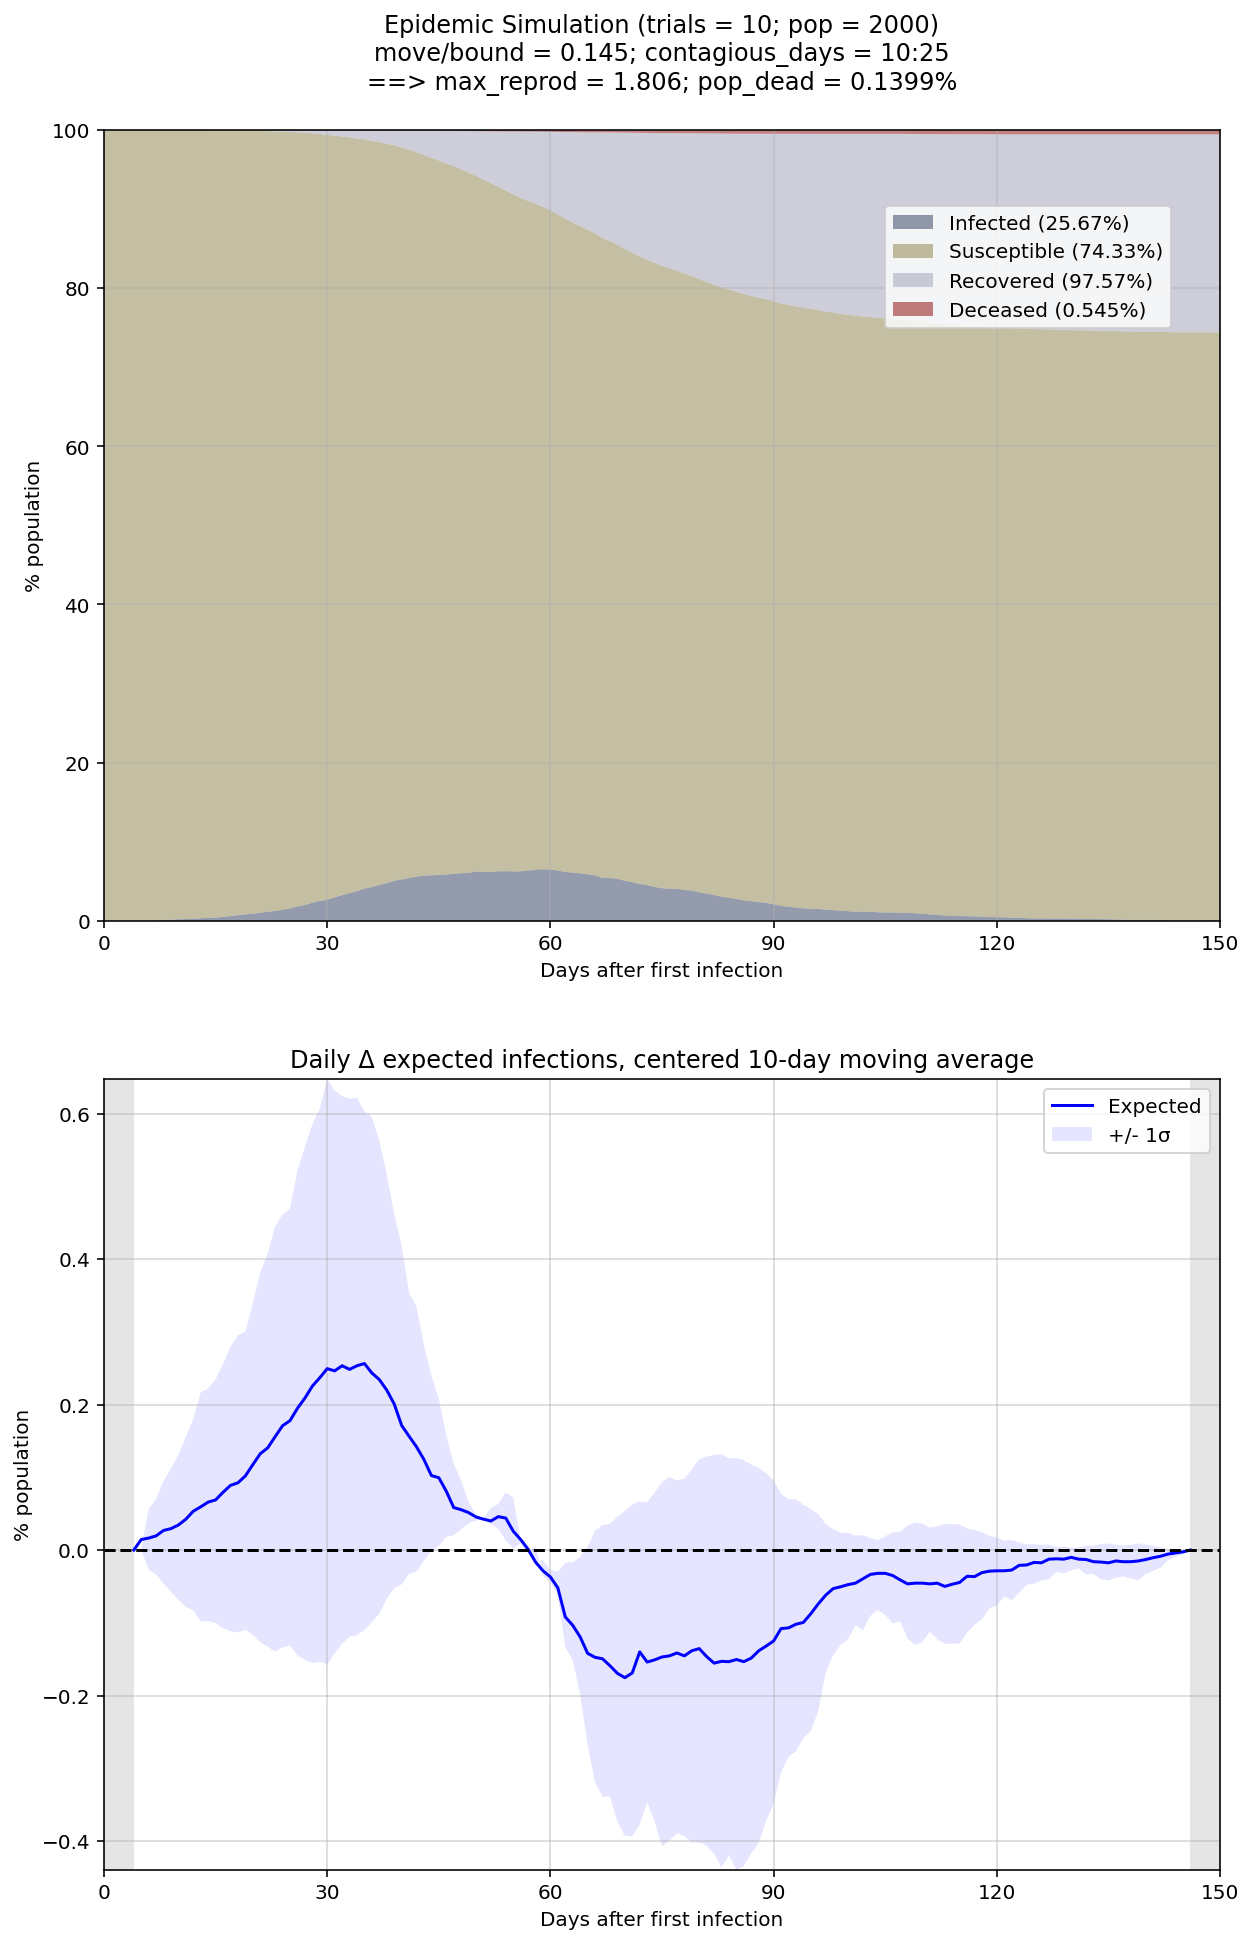

Est. running time: 19008s (???)
Elapsed time: 458.4s
Output ID: 1586442056


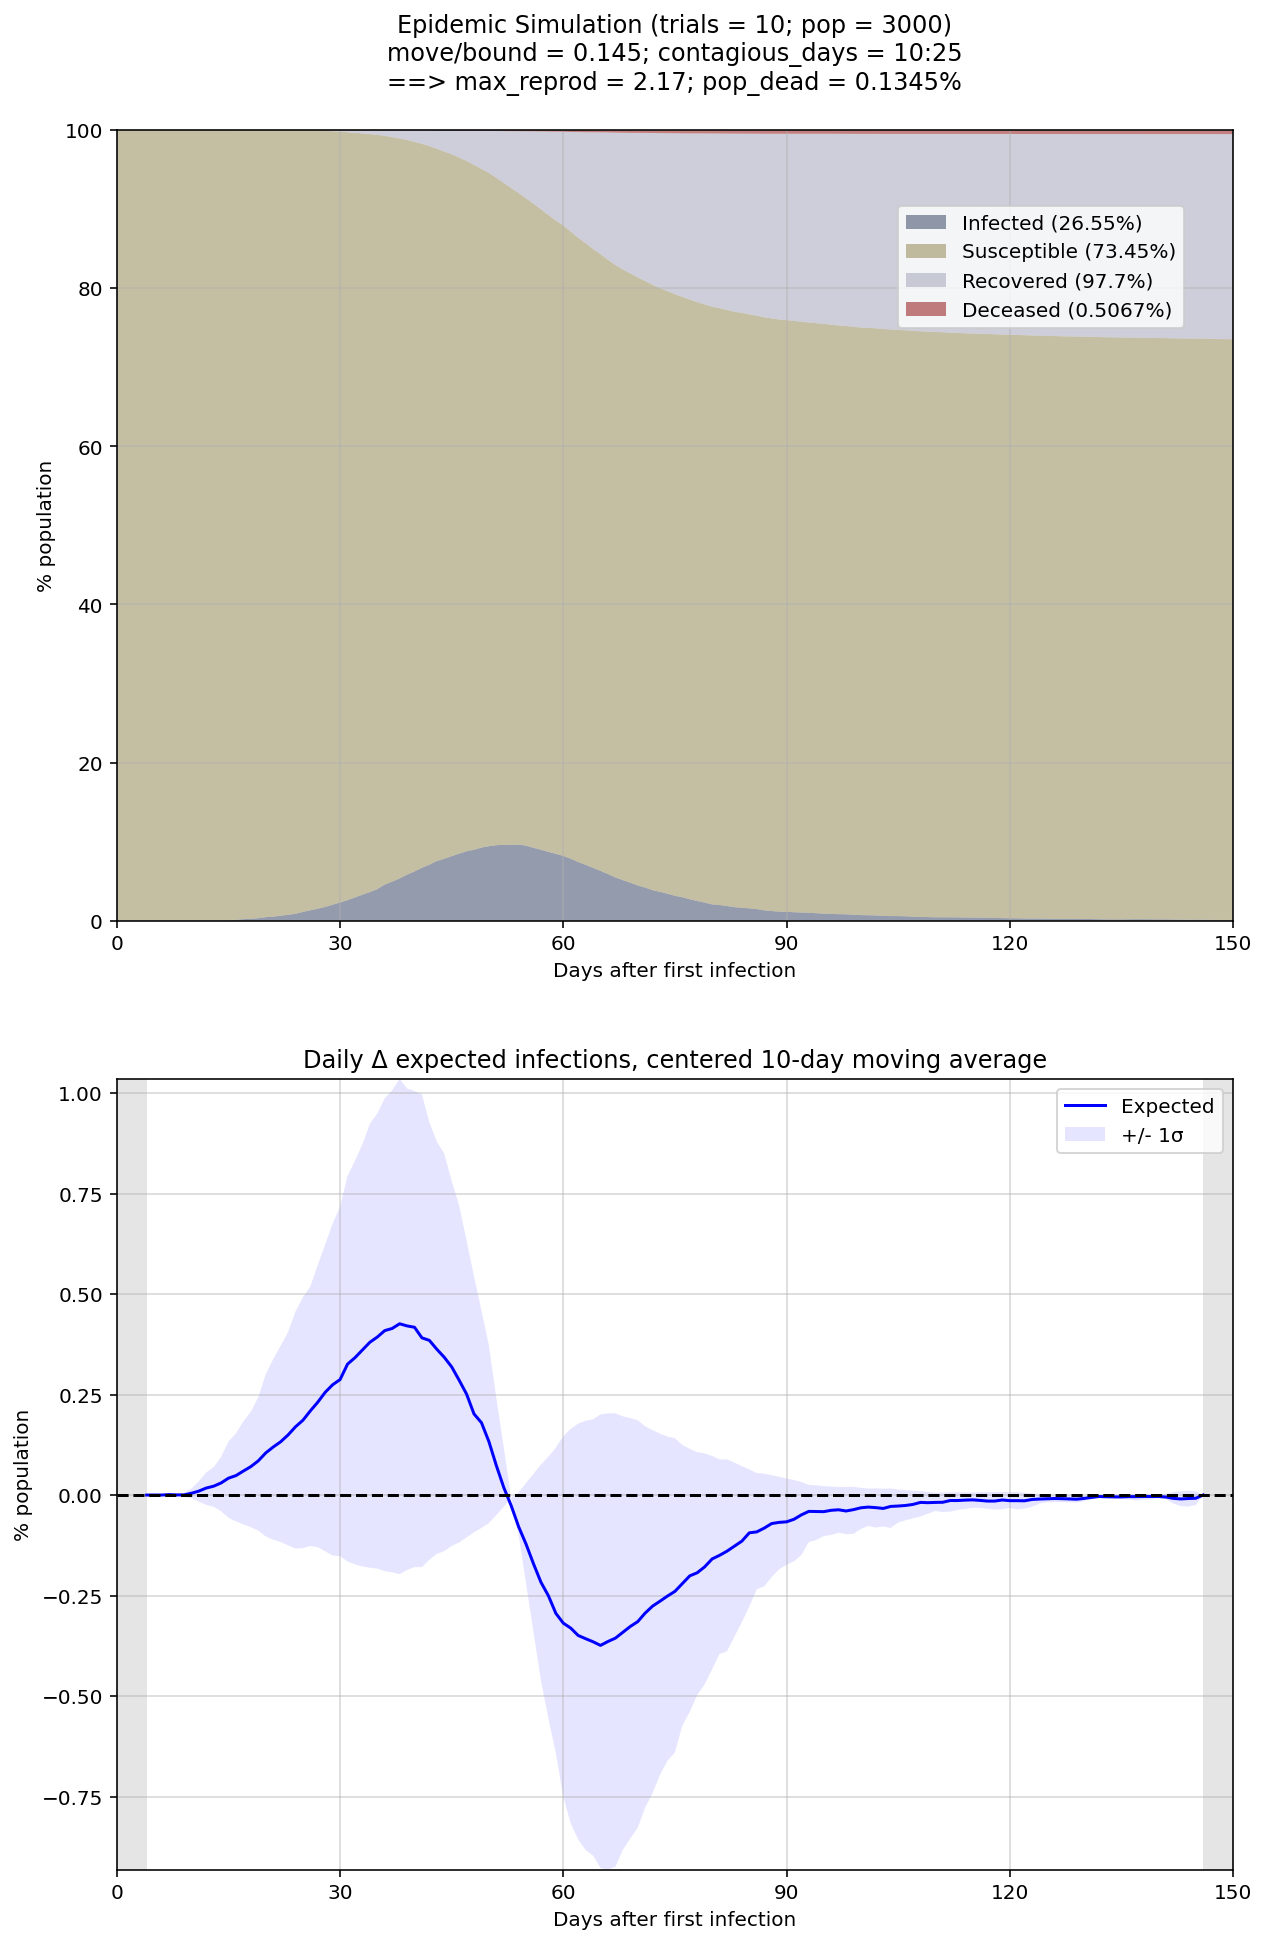

Est. running time: 33739s (???)
Elapsed time: 1015.0s
Output ID: 1586443077


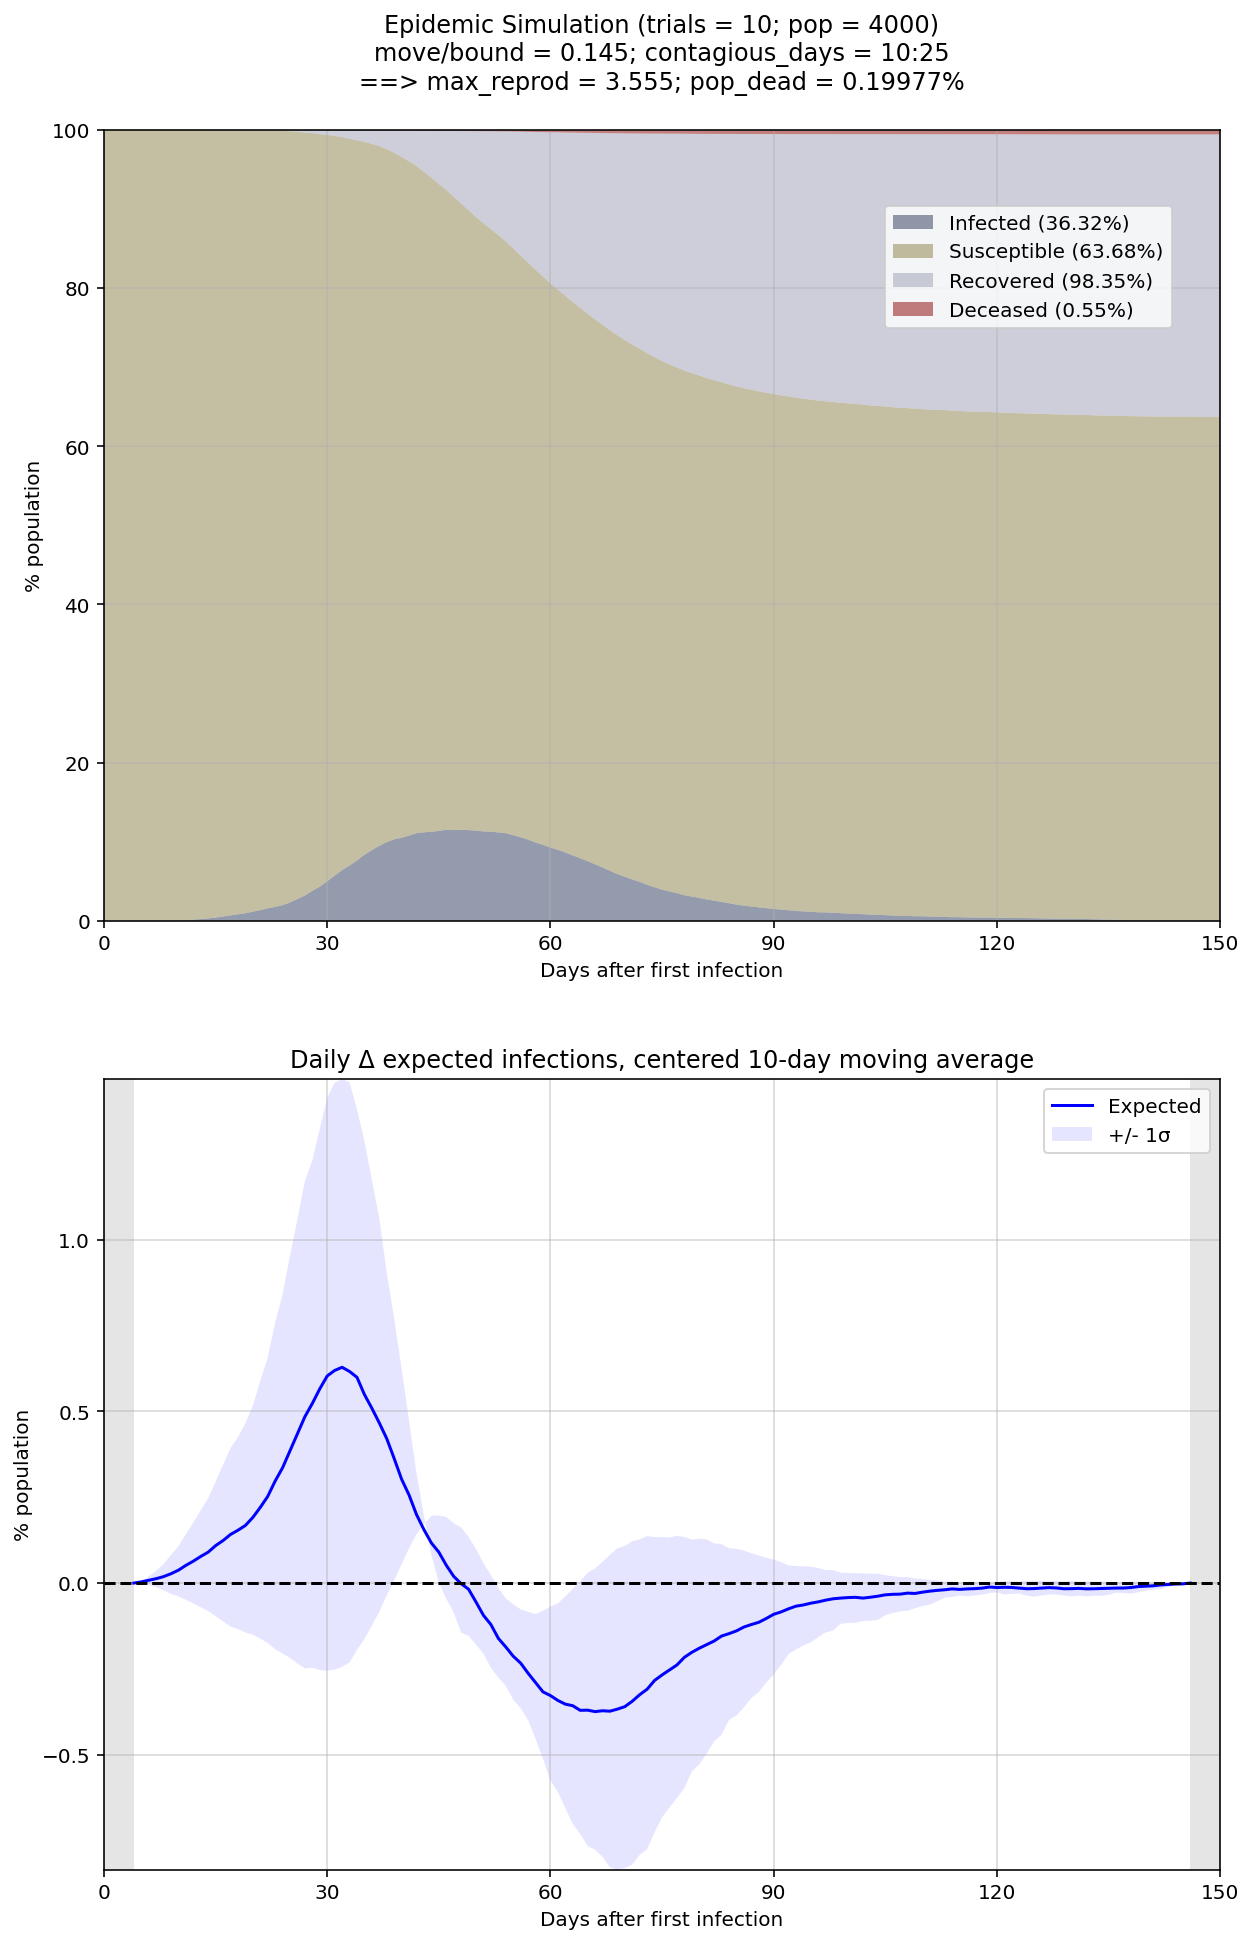

Est. running time: 52668s (???)
Elapsed time: 2322.1s
Output ID: 1586445406


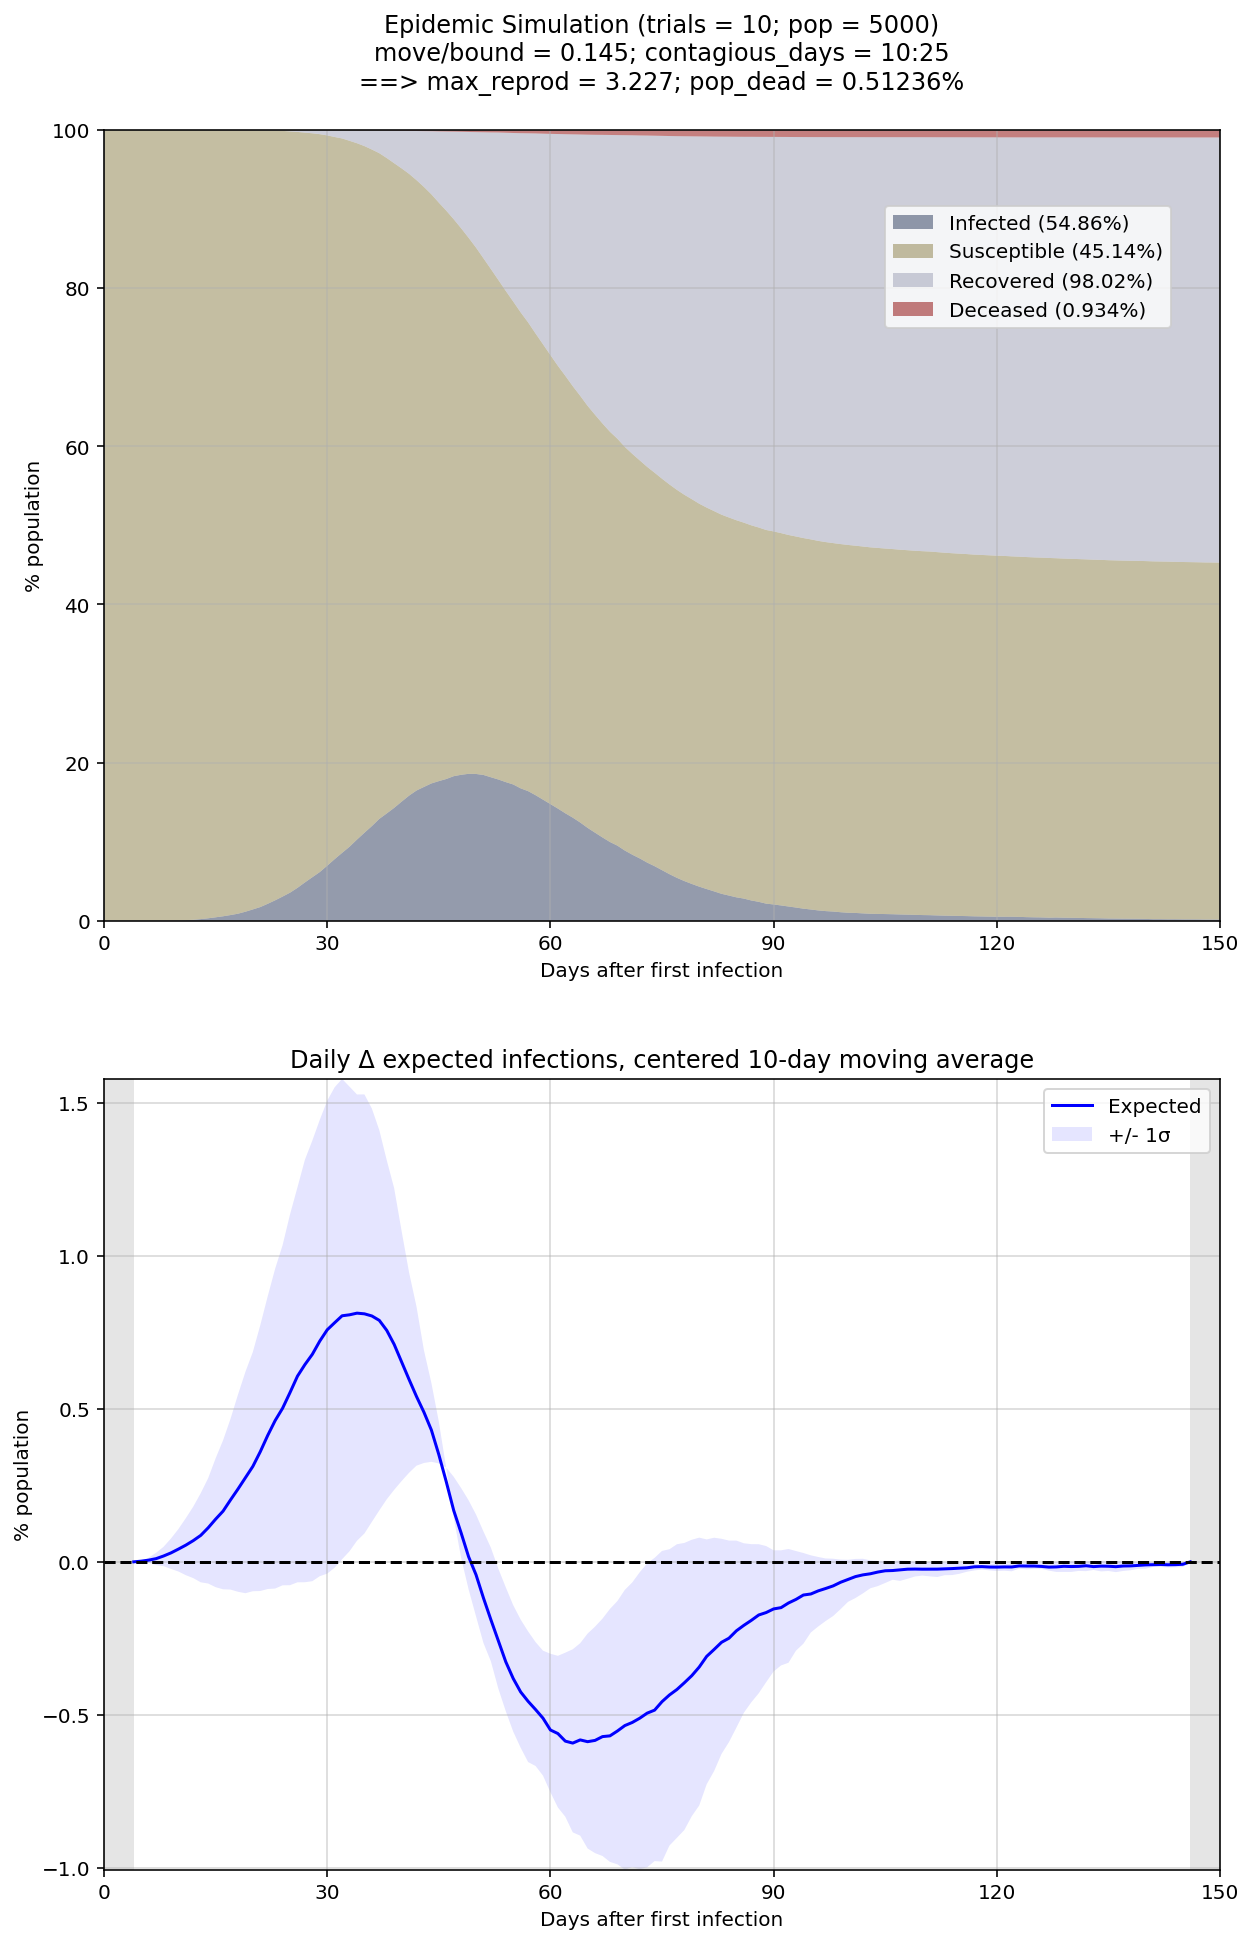

In [0]:
for p in [1000, 2000, 3000, 4000, 5000]:
  inputPopulationSize = p
  simulate()
  time.sleep(5)